## Overview
- I will perform electricity demand forecasting using the data provided in a Google Colaboratory notebook.
- For instructions on using Google Colaboratory, please refer to this [link](https://colab.research.google.com/?hl=ja#scrollTo=Wf5KrEb6vrkR).
- The provided data consists of two types:
  - electricity_demand.csv: Electricity demand values within the Kansai Electric Power (JP) jurisdiction.
  - {location}.csv: Actual weather data for specific locations.

## Rules
- The forecasting target period is January 1, 2023, 00:00:00 – December 31, 2023, 23:00:00.
- Electricity demand values can only be used up until 23:00:00 of the day before the target date.
- There are no restrictions on forecasting methods (choose methods available in the free-tier plan).
- The use of additional data from libraries such as jpholiday is permitted.
  - If additional libraries are used, include the installation command in the notebook (e.g., ! pip install pandas).

## Required Deliverables
Use both code and Markdown as needed to provide the following information:

- Model Development for Electricity Demand Forecasting
  - Justify the choice of method and, if applicable, describe any hypotheses regarding feature engineering.
- Evaluation of Forecasting Performance Using Actual Data
  - Specify and justify the selected evaluation metrics.
- Error Analysis and Model Challenges
- Discuss issues identified through error analysis.
- Hypotheses for Accuracy Improvement
  - Provide potential strategies for enhancing model performance.
- Expected Benefits of Model Deployment
  - Explain the potential impact and advantages of implementing the model.

## Submission
- Once coding and execution are completed in Google Colaboratory, download the executed notebook and submit it.
- Submit your notebook through the designated agent.


INSTALLING THE LIBRARIES

In [86]:
!pip install numpy  # Installs NumPy, a library for numerical computing and array operations
!pip install pandas  # Installs pandas, used for data manipulation and analysis
!pip install matplotlib  # Installs Matplotlib, a plotting library for data visualization
!pip install seaborn  # Installs Seaborn, an advanced statistical data visualization library based on Matplotlib
!pip install scikit-learn  # Installs Scikit-learn, a machine learning library for Python
!pip install jpholiday  # Installs jpholiday, a library for handling Japanese public holidays

IMPORTING THE PACKAGES

In [87]:
import pandas as pd  # Imports pandas for data manipulation and analysis
import numpy as np  # Imports NumPy for numerical computing and array operations
import matplotlib.pyplot as plt  # Imports Matplotlib for data visualization
import seaborn as sns  # Imports Seaborn, an advanced statistical data visualization library

import os  # Imports the os module for interacting with the operating system
import jpholiday  # Imports jpholiday, a library for handling Japanese public holidays

# Importing machine learning components from Scikit-learn
from sklearn.ensemble import RandomForestRegressor  # Imports Random Forest Regressor, an ensemble learning method for regression
from sklearn.metrics import mean_squared_error, r2_score  # Imports metrics to evaluate regression models
from sklearn.model_selection import GridSearchCV  # Imports GridSearchCV for hyperparameter tuning using exhaustive search
from sklearn.model_selection import RandomizedSearchCV  # Imports RandomizedSearchCV for hyperparameter tuning using randomized search

import warnings  # Imports the warnings module to handle warnings
warnings.filterwarnings('ignore')  # Suppresses warnings to keep the output clean


FILES UPLOAD AND THEIR RESPECTIVE PATHS IN GOOGLE COLLAB->


Uploaded CSV file paths

hikone_path = "/content/hikone.csv"  # Path to Hikone dataset

kobe_path = "/content/kobe.csv"  # Path to Kobe dataset
kyoto_path = "/content/kyoto.csv"  # Path to Kyoto dataset

nara_path = "/content/nara.csv"  # Path to Nara dataset

osaka_path = "/content/osaka.csv"  # Path to Osaka dataset

shionomisaki_path = "/content/shionomisaki.csv"  # Path to Shionomisaki dataset

toyooka_path = "/content/toyooka.csv"  # Path to Toyooka dataset

wakayama_path = "/content/wakayama.csv"  # Path to Wakayama dataset

demand_path = "/content/demand.csv"  # Path to Demand dataset

Data Loading and Preprocessing

In [88]:
# Load the electricity demand dataset
demand_data = pd.read_csv("/content/demand.csv")

# Display an overview of the data
print("Electricity Demand Dataset Overview:")
display(demand_data.head())

Electricity Demand Dataset Overview:


datetime  actual_performance(10  000 kW)
0  2021-01-01 00:00:00                   1571      NaN
1  2021-01-01 01:00:00                   1492      NaN
2  2021-01-01 02:00:00                   1453      NaN
3  2021-01-01 03:00:00                   1412      NaN
4  2021-01-01 04:00:00                   1358      NaN

In [89]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               26280 non-null  object 
 1   actual_performance(10  26280 non-null  int64  
 2   000 kW)                0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 616.1+ KB


The dataset consists of 26,280 entries and 3 columns.
Columns:
1. 'datetime' (object type) – Contains date and time values for each entry.
2. 'actual_performance(10' (int64 type) – Represents some performance metric in integer format.
3. '000 kW)' (float64 type) – This column contains only null values, meaning it has no useful data.

The dataset occupies approximately 616.1 KB of memory.
The presence of a completely empty column ('000 kW)') suggests a potential data formatting or parsing issue.
So, removing that column.

In [90]:
# Remove the incorrectly split column if it exists
demand_data = demand_data.drop(columns=["000 kW)"], errors='ignore')

# Rename the misformatted column for clarity
demand_data = demand_data.rename(columns={'actual_performance(10': 'actual_performance'})

# Convert the 'datetime' column to a proper datetime format
demand_data['datetime'] = pd.to_datetime(demand_data['datetime'], format="%Y-%m-%d %H:%M:%S")

# Check for any missing values in the dataset
print("\nCount of missing values in the dataset:\n", demand_data.isna().sum())

# Preview the cleaned dataset
display(demand_data.head())


Count of missing values in the dataset:
 datetime              0
actual_performance    0
dtype: int64


datetime  actual_performance
0 2021-01-01 00:00:00                1571
1 2021-01-01 01:00:00                1492
2 2021-01-01 02:00:00                1453
3 2021-01-01 03:00:00                1412
4 2021-01-01 04:00:00                1358

In [91]:
# Export the cleaned demand data to a new CSV file
demand_data.to_csv("/content/demand_preprocessed.csv", index=False)

# Confirm successful saving of the file
print("The preprocessed electricity demand dataset has been saved as 'demand_preprocessed.csv'.")

The preprocessed electricity demand dataset has been saved as 'demand_preprocessed.csv'.


In [92]:
# List of weather dataset filenames with directory path
weather_filenames = ["/content/hikone.csv", "/content/kobe.csv", "/content/kyoto.csv",
                     "/content/nara.csv", "/content/osaka.csv", "/content/shionomisaki.csv",
                     "/content/toyooka.csv", "/content/wakayama.csv"]

# Define standardized column names
weather_columns = ["datetime", "precipitation", "temperature", "dew_point_temperature",
                   "humidity", "wind_speed", "wind_direction", "snowfall"]

# Dictionary to store the loaded weather data
weather_data_dict = {}

# Load and process each weather dataset
for filename in weather_filenames:
    weather_df = pd.read_csv(filename, names=weather_columns, header=0)

    # Convert 'datetime' to proper datetime format
    weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])

    # Ensure numerical columns have the correct data type
    numeric_columns = ["precipitation", "temperature", "dew_point_temperature",
                       "humidity", "wind_speed", "snowfall"]
    weather_df[numeric_columns] = weather_df[numeric_columns].astype(float)

    # Store processed DataFrame in the dictionary
    weather_data_dict[filename] = weather_df

print("\nSuccessfully loaded and processed all weather datasets.")


Successfully loaded and processed all weather datasets.


WIND DIRECTION MAPPING FROM JAPANEESE TO ENGLISH

In [93]:
# Define the wind direction mapping
wind_direction_mapping = {
    "南": "South", "南南西": "South-Southwest", "南南東": "South-Southeast",
    "西": "West", "北西": "Northwest", "南西": "Southwest", "西北西": "West-Northwest",
    "西南西": "West-Southwest", "南東": "Southeast", "北北西": "North-Northwest",
    "北東": "Northeast", "東南東": "East-Southeast", "東": "East", "北": "North",
    "北北東": "North-Northeast", "東北東": "East-Northeast", "静穏": "Calm", "×": "Unknown"
}

In [94]:
# Update the 'wind_direction' column in all weather DataFrames using the predefined mapping
for filename, weather_df in weather_data_dict.items():
    if 'wind_direction' in weather_df.columns:
        weather_df['wind_direction'] = weather_df['wind_direction'].map(wind_direction_mapping)

print("\nSuccessfully updated wind direction values across all weather datasets.")



Successfully updated wind direction values across all weather datasets.


In [95]:
# Remove rows with missing wind_direction and ensure correct data types for each DataFrame
for filename, weather_df in weather_data_dict.items():
    initial_row_count = weather_df.shape[0]

    # Drop rows where 'wind_direction' is missing
    weather_df.dropna(subset=["wind_direction"], inplace=True)

    final_row_count = weather_df.shape[0]
    print(f"{filename}: Removed {initial_row_count - final_row_count} rows with missing wind_direction.")

    # Ensure the 'datetime' column is in datetime format
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])


/content/hikone.csv: Removed 0 rows with missing wind_direction.
/content/kobe.csv: Removed 0 rows with missing wind_direction.
/content/kyoto.csv: Removed 1 rows with missing wind_direction.
/content/nara.csv: Removed 0 rows with missing wind_direction.
/content/osaka.csv: Removed 0 rows with missing wind_direction.
/content/shionomisaki.csv: Removed 2 rows with missing wind_direction.
/content/toyooka.csv: Removed 1 rows with missing wind_direction.
/content/wakayama.csv: Removed 1 rows with missing wind_direction.


Making the pre-processed files by removing null values.

In [96]:
# Save all cleaned weather datasets to new files in the /content/ directory
for filename, weather_df in weather_data_dict.items():
    new_filename = f"{filename.replace('.csv', '_preprocessed.csv')}"
    weather_df.to_csv(new_filename, index=False)
    print(f"Preprocessed dataset saved as '{new_filename}'.")

print("\nAll preprocessed weather datasets have been saved successfully.")


Preprocessed dataset saved as '/content/hikone_preprocessed.csv'.
Preprocessed dataset saved as '/content/kobe_preprocessed.csv'.
Preprocessed dataset saved as '/content/kyoto_preprocessed.csv'.
Preprocessed dataset saved as '/content/nara_preprocessed.csv'.
Preprocessed dataset saved as '/content/osaka_preprocessed.csv'.
Preprocessed dataset saved as '/content/shionomisaki_preprocessed.csv'.
Preprocessed dataset saved as '/content/toyooka_preprocessed.csv'.
Preprocessed dataset saved as '/content/wakayama_preprocessed.csv'.

All preprocessed weather datasets have been saved successfully.


In [97]:
# List of preprocessed file paths
preprocessed_file_paths = ["/content/demand_preprocessed.csv", "/content/hikone_preprocessed.csv",
                           "/content/kobe_preprocessed.csv", "/content/kyoto_preprocessed.csv",
                           "/content/nara_preprocessed.csv", "/content/osaka_preprocessed.csv",
                           "/content/shionomisaki_preprocessed.csv", "/content/toyooka_preprocessed.csv",
                           "/content/wakayama_preprocessed.csv"]

# Display the first 5 rows of each preprocessed file
for file_path in preprocessed_file_paths:
    print(f"\nInspecting file: {file_path}")
    data = pd.read_csv(file_path)
    print(f"Shape of the data: {data.shape}")  # This step is unnecessary, just added for extra info
    display(data.head())
    print("=" * 50)


Inspecting file: /content/demand_preprocessed.csv
Shape of the data: (26280, 2)


datetime  actual_performance
0  2021-01-01 00:00:00                1571
1  2021-01-01 01:00:00                1492
2  2021-01-01 02:00:00                1453
3  2021-01-01 03:00:00                1412
4  2021-01-01 04:00:00                1358


Inspecting file: /content/hikone_preprocessed.csv
Shape of the data: (26280, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          0.3                   -4.9   
1  2021-01-01 01:00:00            0.0          0.3                   -4.7   
2  2021-01-01 02:00:00            0.0          0.0                   -4.8   
3  2021-01-01 03:00:00            0.0         -0.8                   -4.7   
4  2021-01-01 04:00:00            0.0          0.2                   -4.0   

   humidity  wind_speed   wind_direction  snowfall  
0      68.0         3.8            South       0.0  
1      69.0         3.7  South-Southwest       0.0  
2      70.0         3.5  South-Southwest       0.0  
3      75.0         2.3  South-Southeast       0.0  
4      73.0         2.5  South-Southwest       0.0


Inspecting file: /content/kobe_preprocessed.csv
Shape of the data: (26280, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          2.2                   -3.7   
1  2021-01-01 01:00:00            0.0          2.5                   -3.4   
2  2021-01-01 02:00:00            0.0          2.1                   -3.2   
3  2021-01-01 03:00:00            0.0          1.5                   -3.9   
4  2021-01-01 04:00:00            0.0          1.8                   -3.7   

   humidity  wind_speed  wind_direction  snowfall  
0      65.0         5.7            West       0.0  
1      65.0         4.3  West-Southwest       0.0  
2      68.0         4.5            West       0.0  
3      67.0         4.5            West       0.0  
4      67.0         3.5            West       0.0


Inspecting file: /content/kyoto_preprocessed.csv
Shape of the data: (26279, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          0.6                   -5.0   
1  2021-01-01 01:00:00            0.0          0.5                   -4.9   
2  2021-01-01 02:00:00            0.0          0.2                   -5.0   
3  2021-01-01 03:00:00            0.0          0.0                   -4.6   
4  2021-01-01 04:00:00            0.0          0.0                   -4.6   

   humidity  wind_speed   wind_direction  snowfall  
0      66.0         2.1  South-Southwest       0.0  
1      67.0         1.5  South-Southwest       0.0  
2      68.0         0.9        Northeast       0.0  
3      71.0         1.8            South       0.0  
4      71.0         2.3        Northwest       0.0


Inspecting file: /content/nara_preprocessed.csv
Shape of the data: (0, 8)


Empty DataFrame
Columns: [datetime, precipitation, temperature, dew_point_temperature, humidity, wind_speed, wind_direction, snowfall]
Index: []


Inspecting file: /content/osaka_preprocessed.csv
Shape of the data: (26280, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          3.1                   -4.1   
1  2021-01-01 01:00:00            0.0          3.0                   -3.8   
2  2021-01-01 02:00:00            0.0          2.9                   -3.4   
3  2021-01-01 03:00:00            0.0          2.6                   -3.9   
4  2021-01-01 04:00:00            0.0          2.4                   -3.3   

   humidity  wind_speed  wind_direction  snowfall  
0      59.0         4.8  West-Southwest       0.0  
1      61.0         4.0  West-Southwest       0.0  
2      63.0         3.2            West       0.0  
3      62.0         3.5  West-Southwest       0.0  
4      66.0         2.8       Southwest       0.0


Inspecting file: /content/shionomisaki_preprocessed.csv
Shape of the data: (26278, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          3.7                   -4.2   
1  2021-01-01 01:00:00            0.0          4.1                   -3.6   
2  2021-01-01 02:00:00            0.0          4.0                   -4.4   
3  2021-01-01 03:00:00            0.0          4.1                   -3.4   
4  2021-01-01 04:00:00            0.0          4.6                   -2.3   

   humidity  wind_speed  wind_direction  snowfall  
0      56.0         6.7  West-Northwest       0.0  
1      57.0         8.0  West-Northwest       0.0  
2      54.0         6.9  West-Northwest       0.0  
3      58.0         7.1  West-Northwest       0.0  
4      61.0         7.0  West-Northwest       0.0


Inspecting file: /content/toyooka_preprocessed.csv
Shape of the data: (26279, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.5         -0.3                   -0.4   
1  2021-01-01 01:00:00            1.5         -0.2                   -0.3   
2  2021-01-01 02:00:00            0.5          0.4                    0.0   
3  2021-01-01 03:00:00            1.0          0.1                    0.1   
4  2021-01-01 04:00:00            0.5          0.2                    0.2   

   humidity  wind_speed   wind_direction  snowfall  
0      99.0         2.1  South-Southeast       1.0  
1      99.0         2.0            South       2.0  
2      97.0         3.5        Southwest       0.0  
3     100.0         2.2  South-Southeast       2.0  
4     100.0         2.8            South       0.0


Inspecting file: /content/wakayama_preprocessed.csv
Shape of the data: (26279, 8)


datetime  precipitation  temperature  dew_point_temperature  \
0  2021-01-01 00:00:00            0.0          2.3                   -1.0   
1  2021-01-01 01:00:00            0.0          3.1                   -2.2   
2  2021-01-01 02:00:00            0.0          3.9                   -4.1   
3  2021-01-01 03:00:00            0.0          3.9                   -3.4   
4  2021-01-01 04:00:00            0.0          3.9                   -3.1   

   humidity  wind_speed  wind_direction  snowfall  
0      79.0         2.6  West-Southwest       0.0  
1      68.0         1.5           North       0.0  
2      56.0         6.2  West-Northwest       0.0  
3      59.0         5.6  West-Northwest       0.0  
4      60.0         5.8  West-Northwest       0.0

DATA MERGING

In [98]:
# Load the preprocessed electricity demand data
demand_data = pd.read_csv("/content/demand_preprocessed.csv")

Merging all the data in one file for model training.

In [99]:
# Convert the 'datetime' column to the correct datetime format
demand_data["datetime"] = pd.to_datetime(demand_data["datetime"])

# Create a copy of the demand data to start the merging process
merged_data = demand_data.copy()

# List of preprocessed weather data files from /content/
weather_files_list = ["/content/hikone_preprocessed.csv", "/content/kobe_preprocessed.csv",
                      "/content/kyoto_preprocessed.csv", "/content/nara_preprocessed.csv",
                      "/content/osaka_preprocessed.csv", "/content/shionomisaki_preprocessed.csv",
                      "/content/toyooka_preprocessed.csv", "/content/wakayama_preprocessed.csv"]

# Merge each weather file with the demand data on 'datetime'
for weather_file in weather_files_list:
    weather_data = pd.read_csv(weather_file)  # Read the weather data
    weather_data["datetime"] = pd.to_datetime(weather_data["datetime"])  # Ensure the datetime format is consistent
    merged_data = merged_data.merge(weather_data, on="datetime", how="left", suffixes=("", f"_{weather_file.split('_')[0]}"))  # Merge the data

print("Weather data has been successfully integrated with the electricity demand data.")

Weather data has been successfully integrated with the electricity demand data.


In [100]:
display(merged_data.head())


datetime  actual_performance  precipitation  temperature  \
0 2021-01-01 00:00:00                1571            0.0          0.3   
1 2021-01-01 01:00:00                1492            0.0          0.3   
2 2021-01-01 02:00:00                1453            0.0          0.0   
3 2021-01-01 03:00:00                1412            0.0         -0.8   
4 2021-01-01 04:00:00                1358            0.0          0.2   

   dew_point_temperature  humidity  wind_speed   wind_direction  snowfall  \
0                   -4.9      68.0         3.8            South       0.0   
1                   -4.7      69.0         3.7  South-Southwest       0.0   
2                   -4.8      70.0         3.5  South-Southwest       0.0   
3                   -4.7      75.0         2.3  South-Southeast       0.0   
4                   -4.0      73.0         2.5  South-Southwest       0.0   

   precipitation_/content/kobe  ...  wind_speed_/content/toyooka  \
0                          0.0  ...                          2.1   
1                          0.0  ...                          2.0   
2                          0.0  ...                          3.5   
3                          0.0  ...                          2.2   
4                          0.0  ...                          2.8   

   wind_direction_/content/toyooka  snowfall_/content/toyooka  \
0                  South-Southeast                        1.0   
1                            South                        2.0   
2                        Southwest                        0.0   
3                  South-Southeast                        2.0   
4                            South                        0.0   

   precipitation_/content/wakayama temperature_/content/wakayama  \
0                              0.0                           2.3   
1                              0.0                           3.1   
2                              0.0                           3.9   
3                              0.0                           3.9   
4                              0.0                           3.9   

   dew_point_temperature_/content/wakayama  humidity_/content/wakayama  \
0                                     -1.0                        79.0   
1                                     -2.2                        68.0   
2                                     -4.1                        56.0   
3                                     -3.4                        59.0   
4                                     -3.1                        60.0   

   wind_speed_/content/wakayama  wind_direction_/content/wakayama  \
0                           2.6                    West-Southwest   
1                           1.5                             North   
2                           6.2                    West-Northwest   
3                           5.6                    West-Northwest   
4                           5.8                    West-Northwest   

   snowfall_/content/wakayama  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0  

[5 rows x 58 columns]

In [101]:
# The 'datetime' column represents the timestamp for each entry in the dataset.
# The 'actual_performance' column holds the electricity demand for that particular time.
# Weather-related columns are included from different weather stations, each with its own suffix:
# - 'precipitation', 'temperature', 'dew_point_temperature', 'humidity', 'wind_speed', 'wind_direction', 'snowfall'
# The suffix after each weather column identifies the respective location, such as 'kobe', 'toyooka', 'wakayama', etc.
# Example: 'precipitation_/content/kobe' refers to precipitation data for the Kobe station.

# Displaying the first row of data:
# datetime: Timestamp when the data was recorded (e.g., "2021-01-01 00:00:00").
# actual_performance: Electricity demand at that time (e.g., 1571).
# Weather data columns:
# - Precipitation: Rainfall amount (e.g., 0.0 mm).
# - Temperature: The temperature recorded at the time (e.g., 0.3°C).
# - Dew Point Temperature: The dew point temperature (e.g., -4.9°C).
# - Humidity: Relative humidity in percentage (e.g., 68.0%).
# - Wind Speed: Speed of wind in m/s (e.g., 3.8 m/s).
# - Wind Direction: The direction of the wind (e.g., 'South').
# - Snowfall: Snowfall amount (e.g., 0.0 mm).
# Each weather station has corresponding data columns, e.g., wind speed for 'toyooka' is 'wind_speed_/content/toyooka'.

# This merged dataset helps in understanding how environmental factors (like weather conditions) might correlate with electricity demand.


In [102]:
# Checking for missing (NaN) values in the merged dataset
# The '.isna().sum()' function is used to count the number of missing values in each column.
# This will help in identifying if any data is missing after merging the weather and demand datasets.
merged_data.isna().sum()


datetime                                           0
actual_performance                                 0
precipitation                                      0
temperature                                        0
dew_point_temperature                              0
humidity                                           0
wind_speed                                         0
wind_direction                                     0
snowfall                                           0
precipitation_/content/kobe                        0
temperature_/content/kobe                          0
dew_point_temperature_/content/kobe                0
humidity_/content/kobe                             0
wind_speed_/content/kobe                           0
wind_direction_/content/kobe                       0
snowfall_/content/kobe                             0
precipitation_/content/kyoto                       1
temperature_/content/kyoto                         1
dew_point_temperature_/content/kyoto               1
humidity_/content/kyoto                            1
wind_speed_/content/kyoto                          1
wind_direction_/content/kyoto                      1
snowfall_/content/kyoto                            1
precipitation_/content/nara                    26280
temperature_/content/nara                      26280
dew_point_temperature_/content/nara            26280
humidity_/content/nara                         26280
wind_speed_/content/nara                       26280
wind_direction_/content/nara                   26280
snowfall_/content/nara                         26280
precipitation_/content/osaka                       0
temperature_/content/osaka                         0
dew_point_temperature_/content/osaka               0
humidity_/content/osaka                            0
wind_speed_/content/osaka                          0
wind_direction_/content/osaka                      0
snowfall_/content/osaka                            0
precipitation_/content/shionomisaki                2
temperature_/content/shionomisaki                  2
dew_point_temperature_/content/shionomisaki        2
humidity_/content/shionomisaki                     2
wind_speed_/content/shionomisaki                   2
wind_direction_/content/shionomisaki               2
snowfall_/content/shionomisaki                     2
precipitation_/content/toyooka                     1
temperature_/content/toyooka                       1
dew_point_temperature_/content/toyooka             1
humidity_/content/toyooka                          1
wind_speed_/content/toyooka                        1
wind_direction_/content/toyooka                    1
snowfall_/content/toyooka                          1
precipitation_/content/wakayama                    1
temperature_/content/wakayama                      1
dew_point_temperature_/content/wakayama            1
humidity_/content/wakayama                         1
wind_speed_/content/wakayama                       1
wind_direction_/content/wakayama                   1
snowfall_/content/wakayama                         1
dtype: int64

In [103]:
# Remove columns related to 'nara' from the merged dataset
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains("nara")]

# Drop rows that contain any missing values (NaN) across the entire dataset
merged_data = merged_data.dropna()


FEATURE ENGINEERING

In [104]:
# Convert 'datetime' column to pandas datetime format
merged_data["datetime"] = pd.to_datetime(merged_data["datetime"])

# Extract year, month, day, hour, and weekday information
merged_data["year"] = merged_data["datetime"].apply(lambda x: x.year)
merged_data["month"] = merged_data["datetime"].apply(lambda x: x.month)
merged_data["day"] = merged_data["datetime"].apply(lambda x: x.day)
merged_data["hour"] = merged_data["datetime"].apply(lambda x: x.hour)
merged_data["weekday"] = merged_data["datetime"].apply(lambda x: x.weekday())

# Extract week of the year and determine if it's a weekend
merged_data["week_of_year"] = merged_data["datetime"].apply(lambda x: x.isocalendar()[1])
merged_data["is_weekend"] = merged_data["weekday"].apply(lambda x: 1 if x >= 5 else 0)

In [105]:
# Add a column to identify holidays
merged_data["is_holiday"] = merged_data["datetime"].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)

In [106]:
merged_data = pd.get_dummies(merged_data, columns=[col for col in merged_data.columns if "wind_direction" in col], drop_first=True)

In [107]:
merged_data.head()

datetime  actual_performance  precipitation  temperature  \
0 2021-01-01 00:00:00                1571            0.0          0.3   
1 2021-01-01 01:00:00                1492            0.0          0.3   
2 2021-01-01 02:00:00                1453            0.0          0.0   
3 2021-01-01 03:00:00                1412            0.0         -0.8   
4 2021-01-01 04:00:00                1358            0.0          0.2   

   dew_point_temperature  humidity  wind_speed  snowfall  \
0                   -4.9      68.0         3.8       0.0   
1                   -4.7      69.0         3.7       0.0   
2                   -4.8      70.0         3.5       0.0   
3                   -4.7      75.0         2.3       0.0   
4                   -4.0      73.0         2.5       0.0   

   precipitation_/content/kobe  temperature_/content/kobe  ...  \
0                          0.0                        2.2  ...   
1                          0.0                        2.5  ...   
2                          0.0                        2.1  ...   
3                          0.0                        1.5  ...   
4                          0.0                        1.8  ...   

   wind_direction_/content/wakayama_Northwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_South  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   wind_direction_/content/wakayama_South-Southeast  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_South-Southwest  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_Southeast  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Southwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Unknown  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   wind_direction_/content/wakayama_West  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                  False   

   wind_direction_/content/wakayama_West-Northwest  \
0                                            False   
1                                            False   
2                                             True   
3                                             True   
4                                             True   

   wind_direction_/content/wakayama_West-Southwest  
0                                             True  
1                  

EXPLORATORY DATA ANALYSIS

The "datetime" column is being converted to datetime format (if not already), and electricity demand over time is being plotted with a green line, with labels, a title, a legend, a grid, rotated x-axis labels, and an optimized layout for readability.

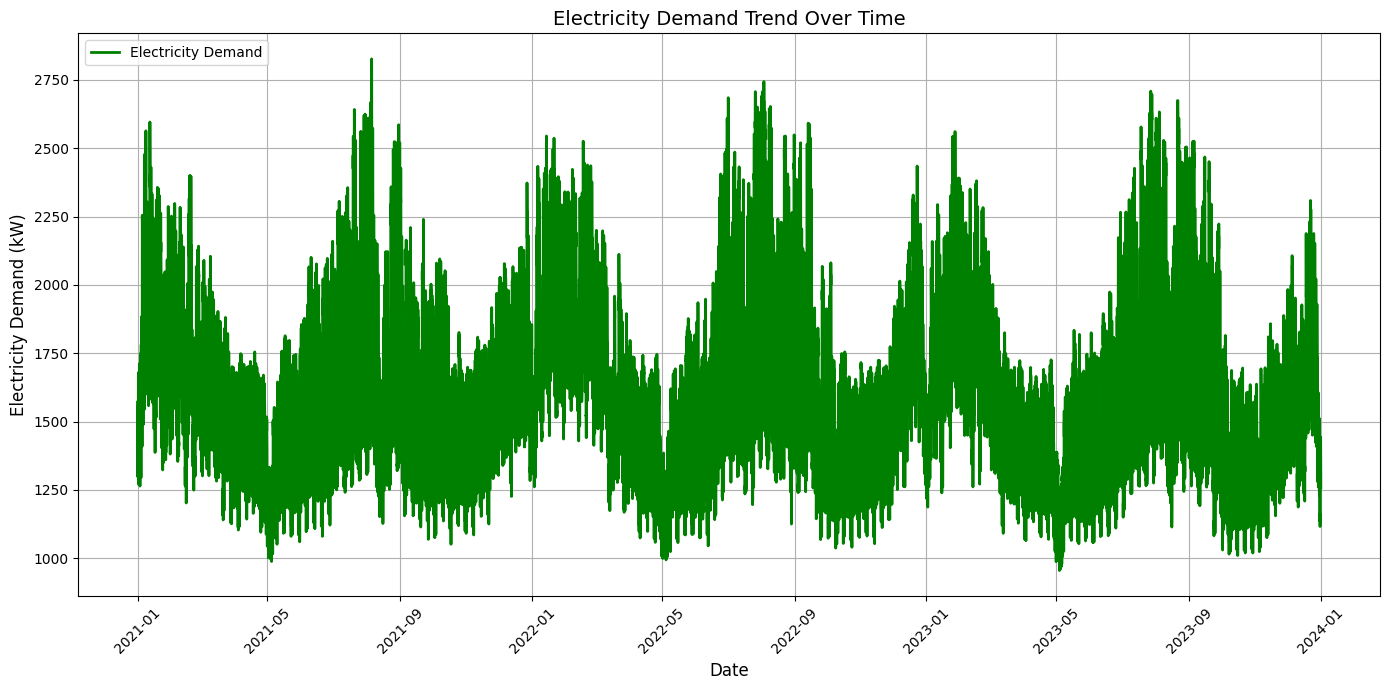

In [108]:
# Convert datetime column to datetime type if not done already
merged_data["datetime"] = pd.to_datetime(merged_data["datetime"])

# Create the plot with updated style
plt.figure(figsize=(14, 7))
plt.plot(merged_data["datetime"], merged_data["actual_performance"], label="Electricity Demand", color="green", linestyle='-', linewidth=2)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand Trend Over Time", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

**Analysis in points:**

**Seasonal Patterns:** The demand follows a clear cyclical pattern, with peaks and troughs occurring at regular intervals, suggesting seasonal variations. Demand is higher in certain months, possibly due to increased heating or cooling needs.

**Yearly Cycles:** Each year, electricity demand appears to dip around the middle of the year (likely summer months) and rise again toward the end and beginning of the year (possibly winter months).

**Overall Growth and Volatility:** While the demand fluctuates within each cycle, there are occasional spikes that could correspond to extreme weather conditions or sudden industrial/economic activity changes.

**Data Granularity:** The high-density time-series data suggests frequent measurements, possibly hourly or daily readings.

**Possible External Influences:** The demand trend may be influenced by economic activity, temperature changes, or policy shifts affecting energy consumption.

In [109]:
####################

A boxplot is being created to visualize the distribution of electricity demand across different weekdays, with weekdays represented on the x-axis (0 = Monday, 6 = Sunday) and electricity demand (kW) on the y-axis. The "magma" color palette is used for styling, and the x-axis labels are replaced with abbreviated weekday names for clarity. The layout is optimized for readability with a grid and adjusted spacing.

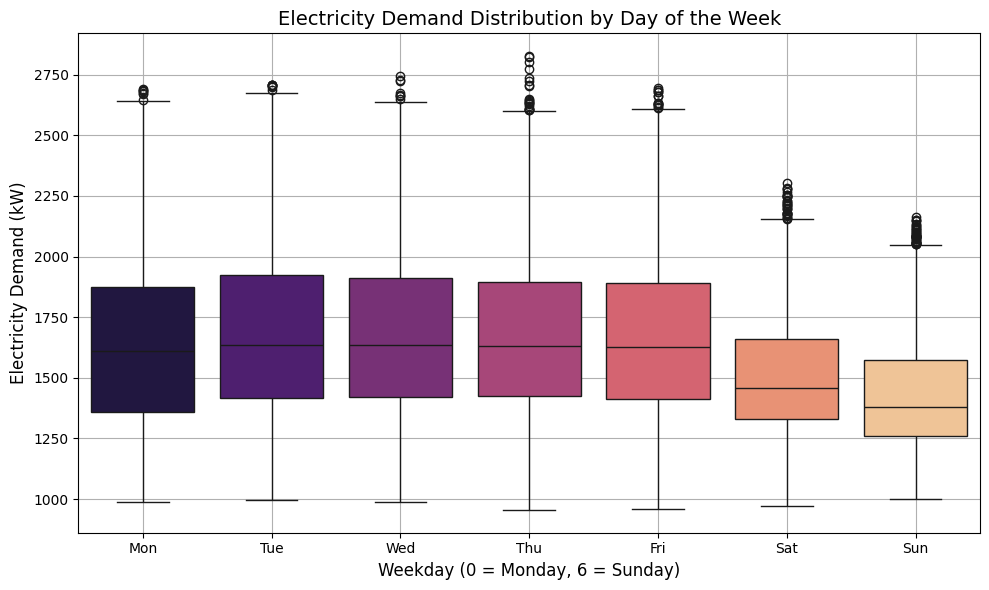

In [110]:
# Extract weekday information if not done already
merged_data["weekday"] = merged_data["datetime"].dt.weekday  # 0 = Monday, 6 = Sunday

# Create the boxplot with updated style
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data["weekday"], y=merged_data["actual_performance"], palette="magma")
plt.xlabel("Weekday (0 = Monday, 6 = Sunday)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand Distribution by Day of the Week", fontsize=14)
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])  # Show abbreviated weekday names
plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

**Analysis in points:**

**Weekday vs. Weekend Demand:** Electricity demand appears to be higher on weekdays (Monday to Friday) compared to weekends (Saturday and Sunday), as indicated by the higher median values and overall distribution.

**Median and Spread:** The median demand is fairly consistent from Monday to Friday but shows a noticeable drop on Saturday and Sunday, suggesting lower electricity usage on weekends.


**Interquartile Range (IQR):** The spread of demand is relatively uniform during the weekdays but slightly narrower on weekends, implying more stable but lower demand on those days.

**Demand Variation:** The demand range (whiskers) extends lower on weekends, reinforcing the observation that electricity usage is reduced on those days, possibly due to reduced industrial or commercial activity.

In [111]:
###################

A scatter plot is being created to analyze the relationship between temperature and electricity demand, showing how demand varies with temperature changes.

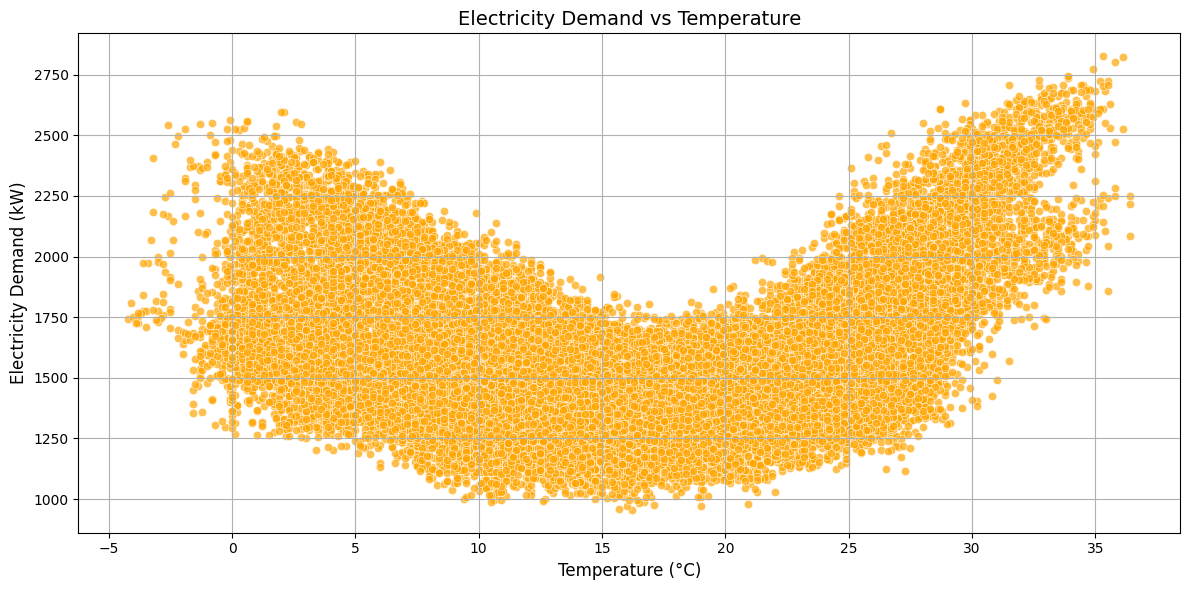

In [112]:
# Create scatter plot to analyze relationship between temperature and electricity demand
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_data["temperature"], y=merged_data["actual_performance"], alpha=0.7, color="orange")
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand vs Temperature", fontsize=14)
plt.grid(True)
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


**Analysis in points:**

The scatter plot shows a U-shaped relationship between temperature (°C) and electricity demand (kW). This indicates that electricity demand is highest at both low and high temperatures, while it is lowest at moderate temperatures.

Key Observations:
High Demand in Extreme Temperatures:

At very low temperatures (-5 to 5°C), electricity demand is high, likely due to increased heating usage.
At very high temperatures (25 to 35°C), demand rises again, likely driven by air conditioning usage.
Lowest Demand at Mild Temperatures (~10-20°C):

Around this range, demand is at its lowest, suggesting that heating and cooling needs are minimal, leading to reduced electricity consumption.
Symmetry in Demand:

The trend is fairly symmetrical, meaning electricity demand behaves similarly at both high and low temperature extremes.
This suggests that both heating in winter and cooling in summer are major contributors to electricity consumption.

In [113]:
########################

A scatter plot is being created to analyze the relationship between temperature and electricity demand, with data points differentiated by weekday using color for additional insights.

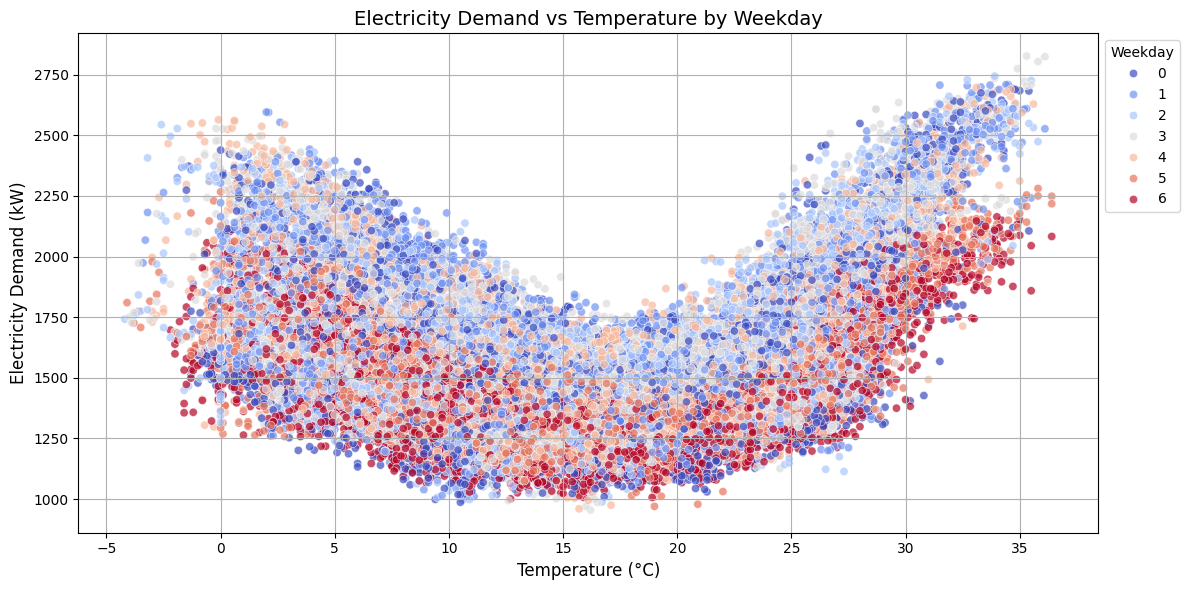

In [114]:
# Create scatter plot to analyze relationship between temperature and electricity demand with hue for additional differentiation
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_data["temperature"], y=merged_data["actual_performance"],
                hue=merged_data["weekday"], palette="coolwarm", alpha=0.7)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand vs Temperature by Weekday", fontsize=14)
plt.legend(title="Weekday", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


**Analysis in Points:**

**U-shaped relationship:** Electricity demand is high at low and high temperatures, lowest around 15°C–20°C.

**Weekday vs. Weekend Difference:** Higher demand on weekdays (blue) due to business activity, lower on weekends (red).

**Extreme Temperature Variability:** Demand is more spread out in very cold (< 0°C) and hot (> 30°C) conditions, likely due to heating/cooling differences.

**Potential Outliers:** Some scattered points indicate unusual demand spikes, possibly due to industrial usage or sudden weather changes.

**Key Insight:** Temperature extremes increase electricity demand, while moderate temperatures reduce it, useful for energy planning and forecasting.

In [115]:
####################

A scatter plot is being created to analyze the relationship between temperature and electricity demand, with data points differentiated by weekday using color and weekends distinguished using marker styles.

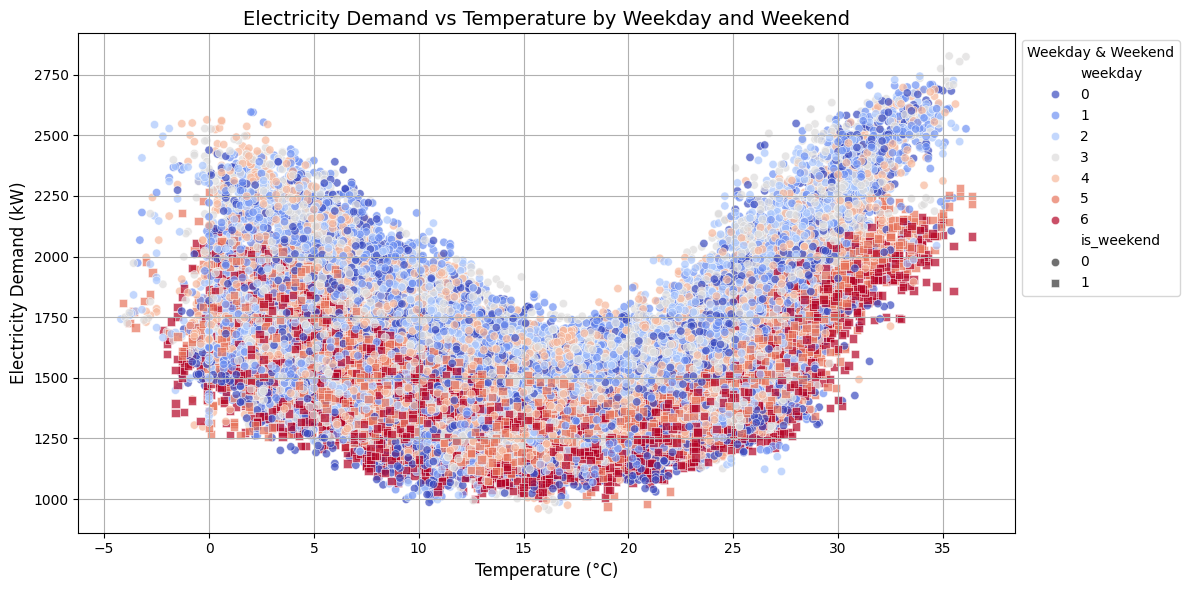

In [116]:
# Create scatter plot to analyze relationship between temperature and electricity demand with multiple hue parameters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_data["temperature"], y=merged_data["actual_performance"],
                hue=merged_data["weekday"], style=merged_data["is_weekend"],
                palette="coolwarm", markers=["o", "s"], alpha=0.7)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand vs Temperature by Weekday and Weekend", fontsize=14)
plt.legend(title="Weekday & Weekend", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


**Analysis in points:**

**U-Shaped Relationship:** The scatter plot shows a U-shaped relationship between temperature and electricity demand, indicating that demand is higher at extreme temperatures (both low and high) and lower at moderate temperatures.

**Weekday and Weekend Differentiation:** The color gradient represents different weekdays, while square markers indicate weekends. Weekday data appears more densely distributed compared to weekends.

**Higher Demand in Cold and Hot Temperatures:** Electricity demand increases sharply below 10°C and above 25°C, likely due to heating and cooling needs.
Lower Demand at Moderate Temperatures: Between 10°C and 20°C, demand is at its lowest, suggesting that less energy is used for climate control in this range.

**Clustered Patterns:** Different weekdays show distinct clustering patterns, with some variations in demand even at similar temperatures, possibly influenced by work schedules and activity levels.

**Higher Weekend Demand at Certain Temperatures:** Weekend data points (square markers) are noticeable in the lower-demand range, suggesting a slightly different consumption pattern compared to weekdays.

In [117]:
#####################################

A box plot is being created to visualize the monthly distribution of electricity demand, showing variations and outliers across different months.

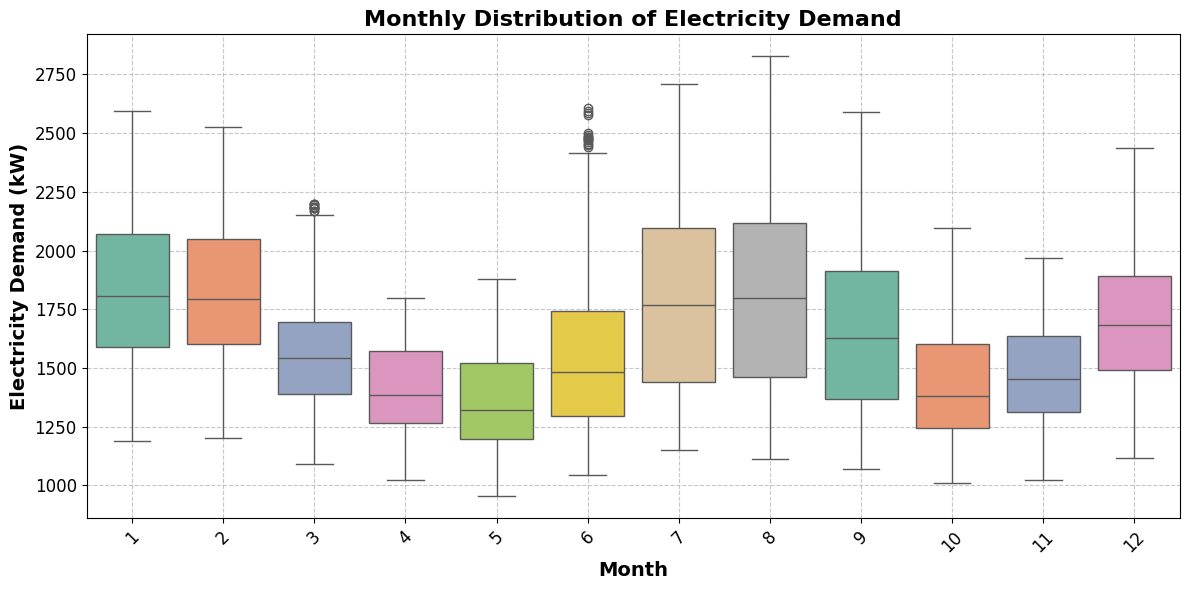

In [118]:
merged_data["month"] = merged_data["datetime"].dt.month

plt.figure(figsize=(12, 6))
sns.boxplot(x=merged_data["month"], y=merged_data["actual_performance"], palette="Set2")
plt.xlabel("Month", fontsize=14, fontweight='bold')
plt.ylabel("Electricity Demand (kW)", fontsize=14, fontweight='bold')
plt.title("Monthly Distribution of Electricity Demand", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


**Analysis in points:**

**Seasonal Variations:** The electricity demand fluctuates across different months, with higher demand observed in January, February, July, and August, possibly due to extreme temperatures requiring heating or cooling.

**Lower Demand Months:** The months of April, May, October, and November show lower median electricity demand, suggesting a period of moderate climate where heating or cooling needs are minimal.

**Outliers:** Several months, especially June and December, exhibit outliers, indicating occasional spikes in electricity demand, which could be due to extreme weather conditions or special events.

**Interquartile Range (IQR) Differences:** Some months, like July and August, have a wider IQR, meaning electricity demand fluctuates significantly within these months. Conversely, months like April and May have a narrower IQR, indicating more stable demand.

**Overall Trend:** There appears to be a cyclical pattern, with peaks during winter and summer, aligning with expected seasonal electricity consumption trends.

In [119]:
########################

A line chart is being plotted to visualize the average electricity demand for each hour of the day, highlighting daily consumption patterns.

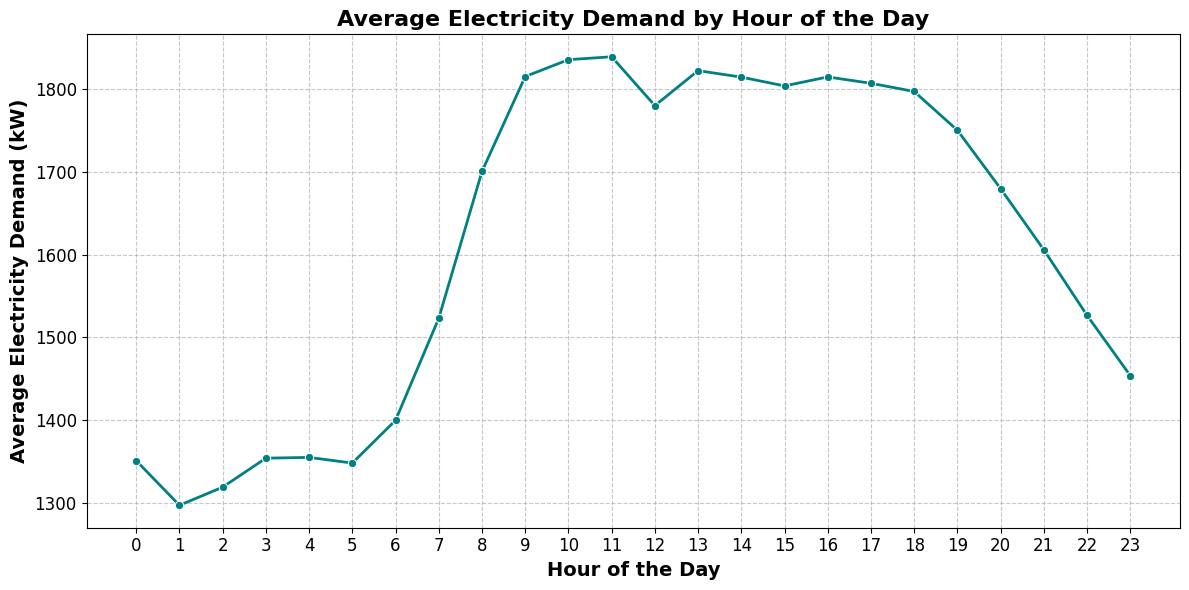

In [120]:
merged_data["hour"] = merged_data["datetime"].dt.hour

plt.figure(figsize=(12, 6))
sns.lineplot(x=merged_data["hour"], y=merged_data["actual_performance"], estimator="mean", ci=None, marker="o", color="teal", linewidth=2)
plt.xlabel("Hour of the Day", fontsize=14, fontweight='bold')
plt.ylabel("Average Electricity Demand (kW)", fontsize=14, fontweight='bold')
plt.title("Average Electricity Demand by Hour of the Day", fontsize=16, fontweight='bold')
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


**Analysis in points:**

**Early Morning Dip (0-5 hrs):** Electricity demand is relatively low between midnight and early morning, with the lowest point around 1 AM.

Gradual Increase (6-8 hrs): A steady rise in demand starts around 6 AM, likely due to people waking up and starting daily activities.

Morning Peak (9-11 hrs): A sharp increase is observed, with demand reaching its highest level around 10-11 AM, possibly due to commercial and industrial activities ramping up.

Midday Fluctuations (12-15 hrs): Demand slightly fluctuates but remains near peak levels, indicating sustained electricity usage during working hours.

Evening Decline (16-20 hrs): A gradual decline starts after 5 PM, as businesses close and energy usage shifts towards residential consumption.

Steep Drop at Night (21-23 hrs): A sharp decline is seen after 8 PM, with demand falling rapidly towards late night hours.

Overall Pattern: The graph follows a typical daily electricity demand curve, with morning and afternoon peaks, and a steady decline after work hours.

In [121]:
######################

A scatter plot is being created to analyze the relationship between wind speed and electricity demand, with data points colored based on the month.

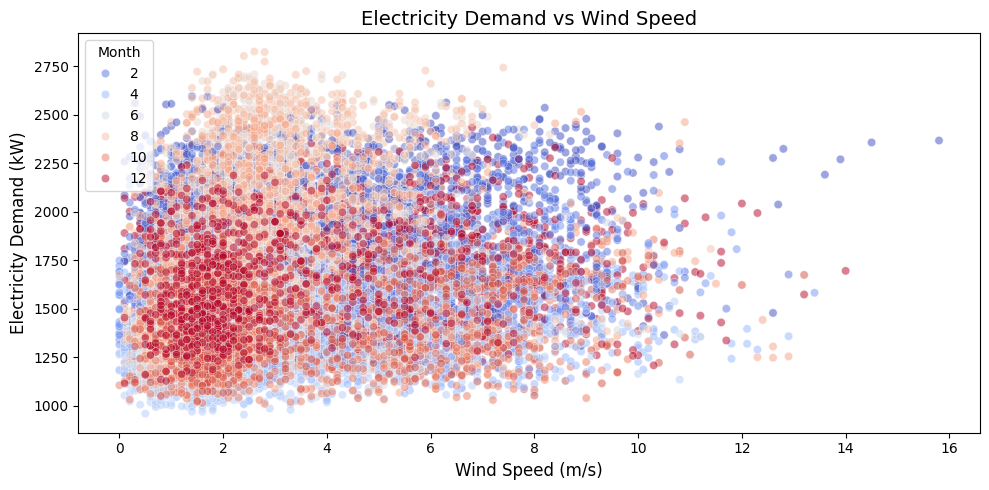

In [122]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=merged_data["wind_speed"], y=merged_data["actual_performance"], alpha=0.5, color="purple", hue=merged_data["month"], palette="coolwarm")
plt.xlabel("Wind Speed (m/s)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand vs Wind Speed", fontsize=14)
plt.legend(title="Month", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


Analysis in points:

General Trend: The data points are widely scattered, indicating that electricity demand does not have a strong linear correlation with wind speed. However, there is a tendency for demand to be lower at very high wind speeds.

Seasonal Variation: The color gradient (coolwarm palette) represents different months, showing how demand changes with seasons. Warmer months (red shades) generally have higher electricity demand, while cooler months (blue shades) have lower demand.

High Density at Low Wind Speeds: A significant concentration of data points is observed at lower wind speeds (0–5 m/s), suggesting that most data points belong to periods with low wind activity.

Outliers and Variability: Some scattered points exist at very high wind speeds (>12 m/s) with varying electricity demand, indicating occasional high wind conditions with fluctuating demand levels.

Possible Interpretation: The higher demand during warmer months could be due to increased cooling needs, while lower demand in colder months might be related to reduced air conditioning usage. Wind speed alone does not seem to be a major factor in electricity demand.

In [123]:
######################

A box plot is being created to compare electricity demand on rainy days versus non-rainy days using a magma color palette.


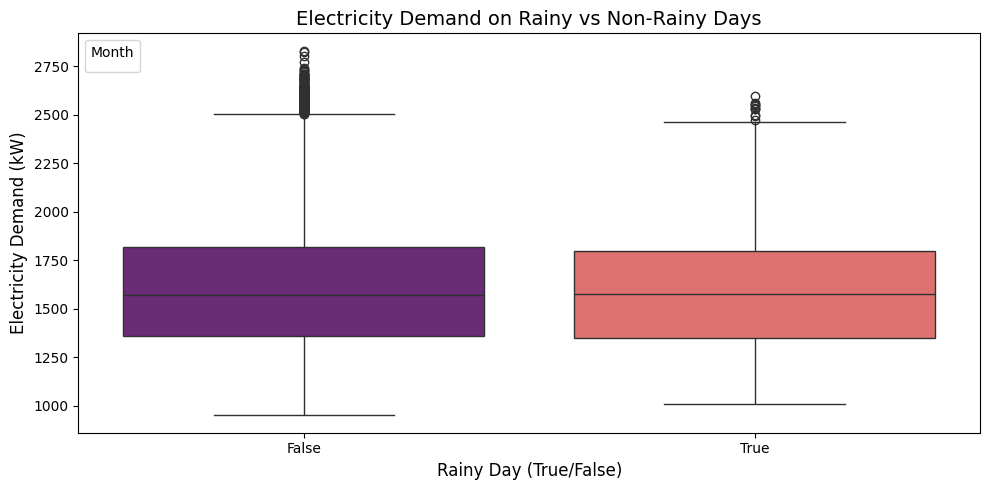

In [124]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=(merged_data["precipitation"] > 0), y=merged_data["actual_performance"], palette="magma")
plt.xlabel("Rainy Day (True/False)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand on Rainy vs Non-Rainy Days", fontsize=14)
plt.legend(title="Month", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


Analysis in points:

Median Comparison: The median electricity demand is similar for both rainy and non-rainy days, indicating that precipitation does not significantly impact the central tendency of demand.

Interquartile Range (IQR): The spread of the middle 50% of data (between Q1 and Q3) is slightly wider for non-rainy days, suggesting a higher variation in demand on those days.

Outliers: There are several outliers in both categories, particularly on non-rainy days, where some extreme values exceed 2500 kW.

Overall Distribution: Both distributions have similar lower and upper bounds, indicating that electricity demand is relatively stable regardless of precipitation.

Whiskers and Extremes: The maximum and minimum demand values are nearly the same for both conditions, suggesting that rain does not cause significant deviations in electricity consumption.

In [125]:
##############

A box plot is being created to compare electricity demand on rainy and non-rainy days, with data grouped by month and color-coded using the "magma" palette.

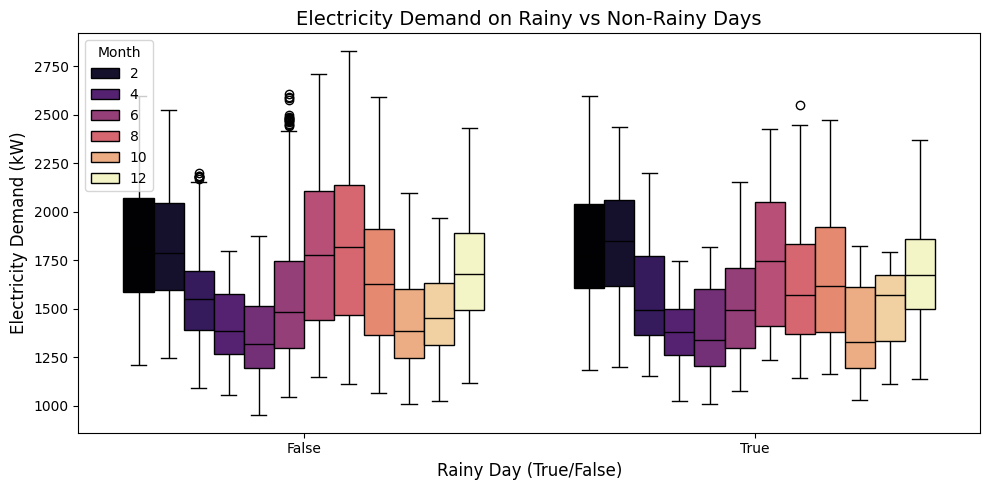

In [126]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=(merged_data["precipitation"] > 0), y=merged_data["actual_performance"], palette="magma", hue=merged_data["month"])
plt.xlabel("Rainy Day (True/False)", fontsize=12)
plt.ylabel("Electricity Demand (kW)", fontsize=12)
plt.title("Electricity Demand on Rainy vs Non-Rainy Days", fontsize=14)
plt.legend(title="Month", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


Analysis in points:

Comparison of Rainy vs Non-Rainy Days: The median electricity demand appears similar between rainy and non-rainy days, indicating that rainfall may not significantly impact electricity demand overall.

Variation Across Months: Different months are represented with varying distributions, suggesting seasonal effects on electricity demand.

Outliers: There are multiple outliers, especially in the non-rainy dataset, indicating occasional spikes in electricity consumption.

Spread of Data: The interquartile range (IQR) varies across months, showing that some months have more variability in demand than others.

Trend Across Months: Warmer months (e.g., lighter colors) tend to have a higher demand compared to colder months, aligning with seasonal electricity consumption patterns.

Rainy Days' Impact by Month: While the overall effect of rain on electricity demand is not drastic, certain months show slightly different distributions between rainy and non-rainy days, implying that rain may influence demand differently based on seasonal conditions.


In [127]:
##############

The proportion of rainy and non-rainy days is being visualized using a pie chart.

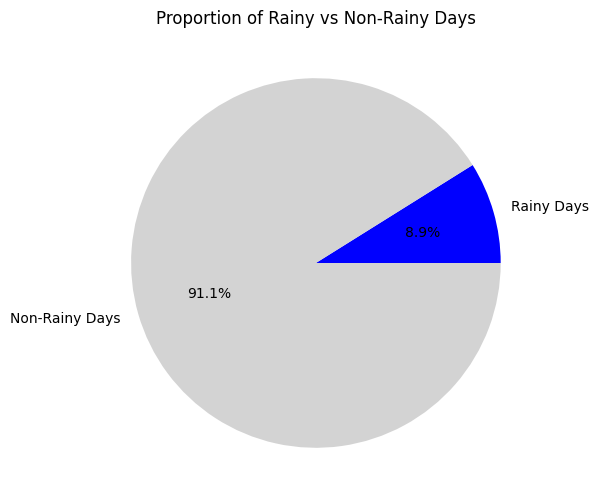

In [128]:
rainy_days = (merged_data["precipitation"] > 0).sum()
non_rainy_days = (merged_data["precipitation"] == 0).sum()

plt.figure(figsize=(6, 6))
plt.pie([rainy_days, non_rainy_days], labels=["Rainy Days", "Non-Rainy Days"], autopct="%1.1f%%", colors=["blue", "lightgray"])
plt.title("Proportion of Rainy vs Non-Rainy Days")
plt.show()


The distribution of electricity demand is being visualized using a histogram with a KDE curve.

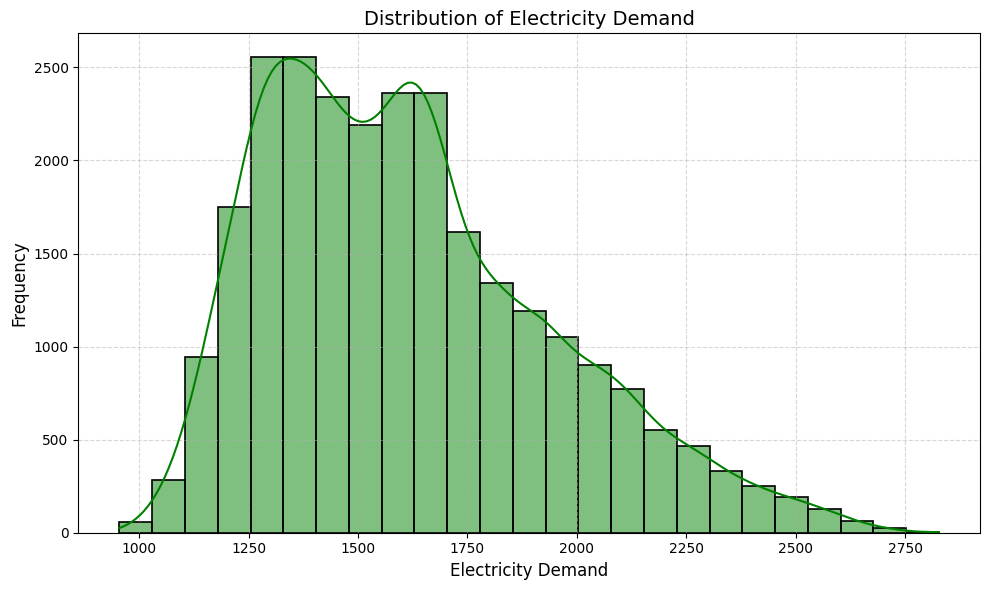

In [129]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_data["actual_performance"], bins=25, kde=True, color="green", edgecolor="black", linewidth=1.2)
plt.xlabel("Electricity Demand", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Electricity Demand", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


Analysis in points:

Right-Skewed Distribution: The electricity demand shows a right-skewed distribution, indicating that most of the demand values are concentrated on the lower end, with a gradual decline towards higher values.

Peak Demand Range: The highest frequency of electricity demand appears between 1250 kW and 1750 kW, suggesting that most observations fall within this range.
Multiple Peaks (Bimodal/Tri-modal Nature): The presence of multiple peaks suggests possible variations in demand patterns, likely influenced by external factors such as time of day, seasonality, or weather conditions.

Long Tail: The demand extends beyond 2500 kW, though these high values are relatively rare, possibly representing peak load conditions or outlier events.
Smooth KDE Curve: The KDE (Kernel Density Estimation) curve provides a smooth approximation of the distribution, aligning well with the histogram bars and reinforcing the observed trends.

Consistent Binning: The chosen bin width provides a balanced view of data granularity, avoiding excessive noise while maintaining clear insights.
Potential Outliers: The tail extending beyond 2500 kW suggests occasional spikes in electricity demand that may warrant further investigation into their causes.

In [130]:
###########

The correlation between variables in `merged_data` is being visualized using a heatmap to identify relationships and dependencies.

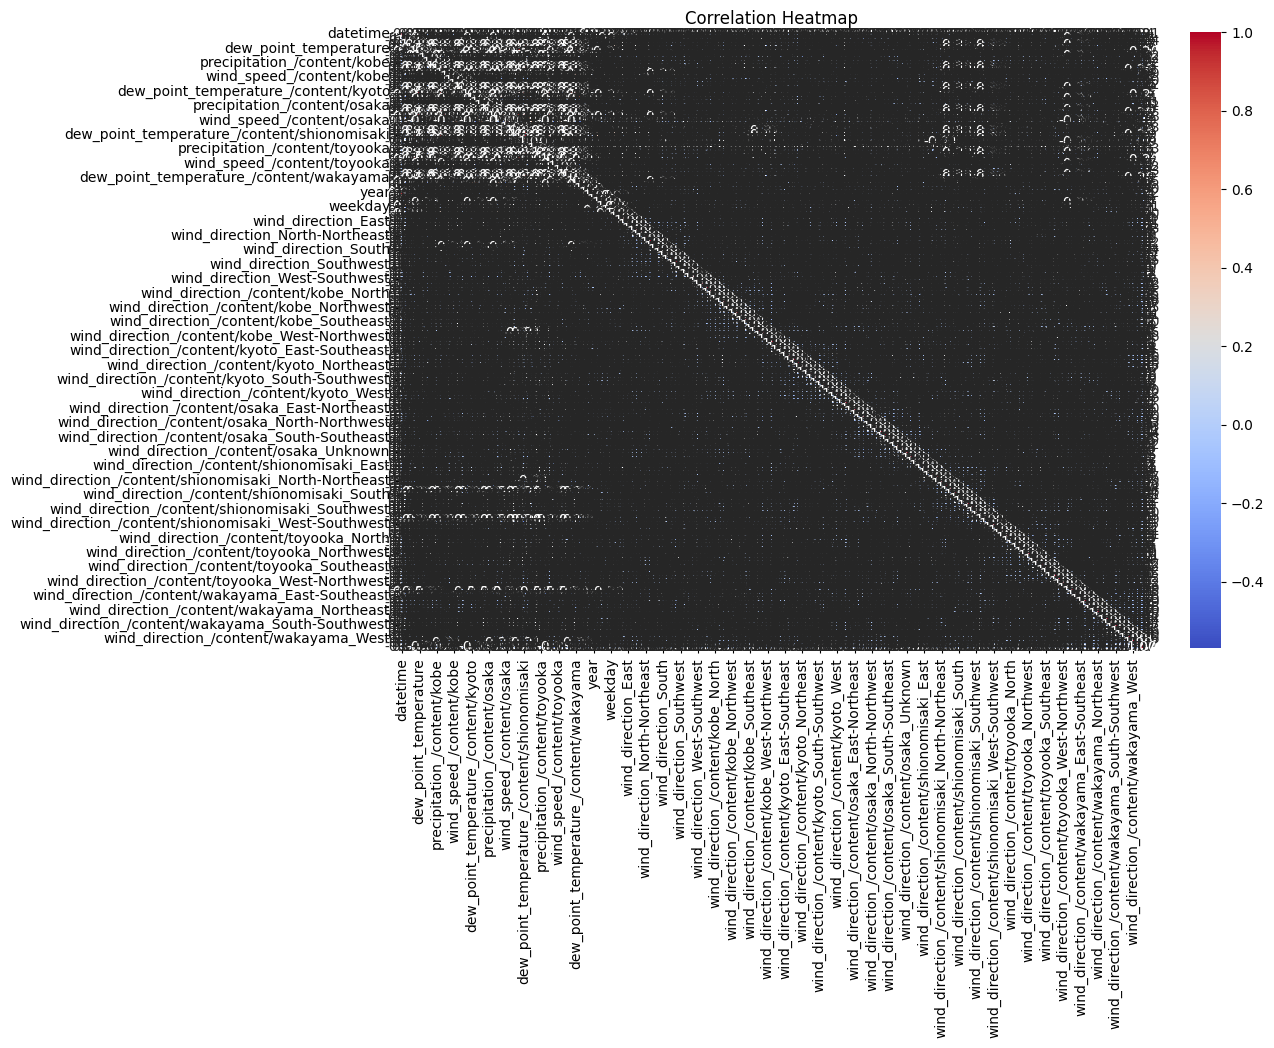

In [131]:
#Heatmap of Correlation Between Variables
plt.figure(figsize=(12, 8))
corr_matrix = merged_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


Analysis in points:

Diagonal Line of Perfect Correlation – The diagonal represents a perfect correlation (value of 1) since each variable is fully correlated with itself.

Strongly Correlated Variables – Some variables exhibit high positive or negative correlations, indicated by deep red or deep blue colors, respectively. These relationships suggest dependencies between those variables.

In [132]:
##############

A violin plot is being created to visualize the distribution of electricity demand for each hour of the day, showing density and quartile information.

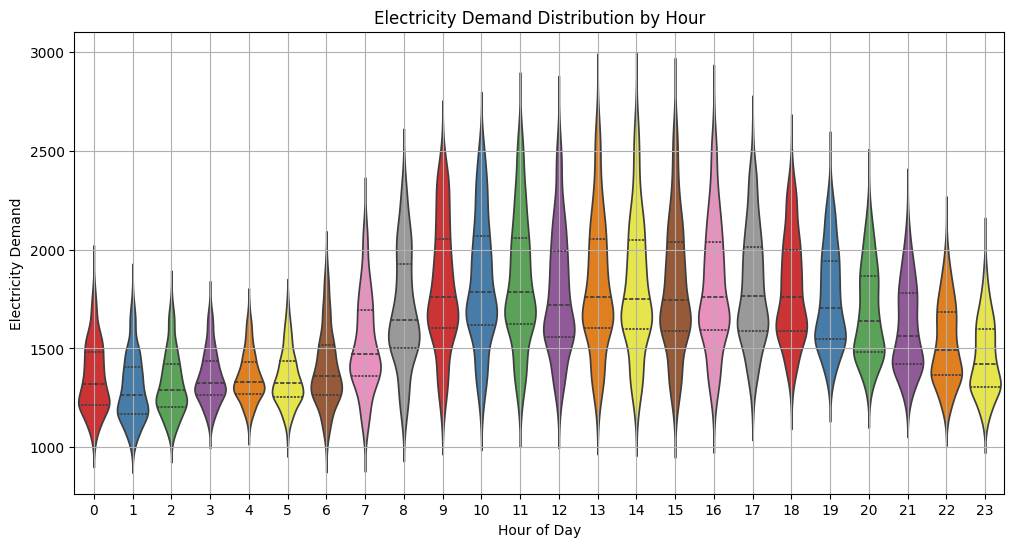

In [133]:
#Violin Plot for Hourly Demand Distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x=merged_data["hour"], y=merged_data["actual_performance"],
               inner="quart", palette="Set1")
plt.xlabel("Hour of Day")
plt.ylabel("Electricity Demand")
plt.title("Electricity Demand Distribution by Hour")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


Analysis in points:

Hourly Distribution: The plot shows the distribution of electricity demand for each hour of the day, with each violin representing a different hour.

Peak Demand Hours: Electricity demand is higher between 7 AM and 8 PM, with the widest distributions occurring around midday and early evening.

Lowest Demand Hours: Demand is lowest between midnight and early morning (0 AM - 6 AM), with narrower distributions indicating lower variability.

Variability: Wider violins suggest greater fluctuations in demand at those hours, while narrower ones indicate more stable demand.

Median and Quartiles: The black horizontal lines inside each violin represent the interquartile range (IQR) and median demand at each hour.

Symmetry and Skewness: Some violins are symmetric, indicating a normal distribution of demand, while others show skewness, suggesting outliers or shifts in consumption behavior.

Early Morning Rise: There is a gradual increase in demand from around 6 AM, which aligns with morning activities starting.

Evening Drop: Demand starts decreasing after 8 PM, which is expected as businesses and households reduce consumption at night.

DATA SPLITTING

In [134]:
merged_data.head()

datetime  actual_performance  precipitation  temperature  \
0 2021-01-01 00:00:00                1571            0.0          0.3   
1 2021-01-01 01:00:00                1492            0.0          0.3   
2 2021-01-01 02:00:00                1453            0.0          0.0   
3 2021-01-01 03:00:00                1412            0.0         -0.8   
4 2021-01-01 04:00:00                1358            0.0          0.2   

   dew_point_temperature  humidity  wind_speed  snowfall  \
0                   -4.9      68.0         3.8       0.0   
1                   -4.7      69.0         3.7       0.0   
2                   -4.8      70.0         3.5       0.0   
3                   -4.7      75.0         2.3       0.0   
4                   -4.0      73.0         2.5       0.0   

   precipitation_/content/kobe  temperature_/content/kobe  ...  \
0                          0.0                        2.2  ...   
1                          0.0                        2.5  ...   
2                          0.0                        2.1  ...   
3                          0.0                        1.5  ...   
4                          0.0                        1.8  ...   

   wind_direction_/content/wakayama_Northwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_South  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   wind_direction_/content/wakayama_South-Southeast  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_South-Southwest  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_Southeast  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Southwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Unknown  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   wind_direction_/content/wakayama_West  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                  False   

   wind_direction_/content/wakayama_West-Northwest  \
0                                            False   
1                                            False   
2                                             True   
3                                             True   
4                                             True   

   wind_direction_/content/wakayama_West-Southwest  
0                                             True  
1                  

In [135]:
merged_data.tail(5)  # Shows the last 5 rows


datetime  actual_performance  precipitation  temperature  \
26275 2023-12-31 19:00:00                1427            0.0         10.3   
26276 2023-12-31 20:00:00                1392            0.0         10.1   
26277 2023-12-31 21:00:00                1348            1.0          9.2   
26278 2023-12-31 22:00:00                1288            0.5          9.6   
26279 2023-12-31 23:00:00                1258            0.0          9.4   

       dew_point_temperature  humidity  wind_speed  snowfall  \
26275                    5.9      74.0         5.3       0.0   
26276                    5.5      73.0         5.9       0.0   
26277                    7.3      88.0         3.1       0.0   
26278                    6.2      79.0         9.9       0.0   
26279                    6.7      83.0         9.9       0.0   

       precipitation_/content/kobe  temperature_/content/kobe  ...  \
26275                          0.0                       10.9  ...   
26276                          0.0                       10.4  ...   
26277                          0.0                        9.1  ...   
26278                          0.0                        9.3  ...   
26279                          0.5                        9.7  ...   

       wind_direction_/content/wakayama_Northwest  \
26275                                       False   
26276                                       False   
26277                                       False   
26278                                        True   
26279                                       False   

       wind_direction_/content/wakayama_South  \
26275                                   False   
26276                                   False   
26277                                   False   
26278                                   False   
26279                                   False   

       wind_direction_/content/wakayama_South-Southeast  \
26275                                             False   
26276                                             False   
26277                                             False   
26278                                             False   
26279                                             False   

       wind_direction_/content/wakayama_South-Southwest  \
26275                                             False   
26276                                             False   
26277                                             False   
26278                                             False   
26279                                             False   

       wind_direction_/content/wakayama_Southeast  \
26275                                       False   
26276                                       False   
26277                                       False   
26278                                       False   
26279                                       False   

       wind_direction_/content/wakayama_Southwest  \
26275                                       False   
26276                                       False   
26277                                       False   
26278                                       False   
26279                                       False   

       wind_direction_/content/wakayama_Unknown  \
26275                                     False   
26276                                     False   
26277                                     False   
26278                                     False   
26279                                     False   

       wind_direction_/content/wakayama_West  \
26275                                  False   
26276                                  False   
26277                                  False   
26278                                  False   
26279                                  False   

       wind_direction_/content/wakayama_West-Northwest  \
26275                                             True   
26276                                             True   
26277           

In [136]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26275 entries, 0 to 26279
Columns: 171 entries, datetime to wind_direction_/content/wakayama_West-Southwest
dtypes: bool(119), datetime64[ns](1), float64(42), int32(3), int64(6)
memory usage: 13.3 MB


The dataset merged_data is being split into training and testing sets based on the date "2023-01-01." Entries with a datetime before this date are assigned to the training set, while those on or after this date are assigned to the test set. The independent variables (X_train and X_test) are selected by dropping the "actual_performance" and "datetime" columns, while the dependent variable (y_train and y_test) is isolated by selecting only the "actual_performance" column. This process is performed to prepare the data for model training and evaluation.

In [137]:
!pip install tensorflow
!pip install keras

In [138]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26275 entries, 0 to 26279
Columns: 171 entries, datetime to wind_direction_/content/wakayama_West-Southwest
dtypes: bool(119), datetime64[ns](1), float64(42), int32(3), int64(6)
memory usage: 13.3 MB


In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [140]:
# Load and preprocess data
train = merged_data[merged_data["datetime"] < "2023-01-01"]
test = merged_data[merged_data["datetime"] >= "2023-01-01"]

In [141]:
train.head()

datetime  actual_performance  precipitation  temperature  \
0 2021-01-01 00:00:00                1571            0.0          0.3   
1 2021-01-01 01:00:00                1492            0.0          0.3   
2 2021-01-01 02:00:00                1453            0.0          0.0   
3 2021-01-01 03:00:00                1412            0.0         -0.8   
4 2021-01-01 04:00:00                1358            0.0          0.2   

   dew_point_temperature  humidity  wind_speed  snowfall  \
0                   -4.9      68.0         3.8       0.0   
1                   -4.7      69.0         3.7       0.0   
2                   -4.8      70.0         3.5       0.0   
3                   -4.7      75.0         2.3       0.0   
4                   -4.0      73.0         2.5       0.0   

   precipitation_/content/kobe  temperature_/content/kobe  ...  \
0                          0.0                        2.2  ...   
1                          0.0                        2.5  ...   
2                          0.0                        2.1  ...   
3                          0.0                        1.5  ...   
4                          0.0                        1.8  ...   

   wind_direction_/content/wakayama_Northwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_South  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   wind_direction_/content/wakayama_South-Southeast  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_South-Southwest  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_Southeast  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Southwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Unknown  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   wind_direction_/content/wakayama_West  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                  False   

   wind_direction_/content/wakayama_West-Northwest  \
0                                            False   
1                                            False   
2                                             True   
3                                             True   
4                                             True   

   wind_direction_/content/wakayama_West-Southwest  
0                                             True  
1                  

In [142]:
test.head()

datetime  actual_performance  precipitation  temperature  \
17520 2023-01-01 00:00:00                1380            0.0          4.2   
17521 2023-01-01 01:00:00                1331            0.0          4.3   
17522 2023-01-01 02:00:00                1327            0.0          6.3   
17523 2023-01-01 03:00:00                1310            0.0          4.9   
17524 2023-01-01 04:00:00                1267            0.0          4.9   

       dew_point_temperature  humidity  wind_speed  snowfall  \
17520                    1.6      83.0         2.3       0.0   
17521                   -0.1      73.0         2.3       0.0   
17522                   -0.2      63.0         2.9       0.0   
17523                   -0.7      67.0         2.1       0.0   
17524                   -1.1      65.0         4.0       0.0   

       precipitation_/content/kobe  temperature_/content/kobe  ...  \
17520                          0.0                        6.0  ...   
17521                          0.0                        5.4  ...   
17522                          0.0                        5.1  ...   
17523                          0.0                        5.0  ...   
17524                          0.0                        5.5  ...   

       wind_direction_/content/wakayama_Northwest  \
17520                                       False   
17521                                        True   
17522                                       False   
17523                                       False   
17524                                       False   

       wind_direction_/content/wakayama_South  \
17520                                   False   
17521                                   False   
17522                                   False   
17523                                   False   
17524                                   False   

       wind_direction_/content/wakayama_South-Southeast  \
17520                                             False   
17521                                             False   
17522                                             False   
17523                                             False   
17524                                             False   

       wind_direction_/content/wakayama_South-Southwest  \
17520                                             False   
17521                                             False   
17522                                             False   
17523                                             False   
17524                                             False   

       wind_direction_/content/wakayama_Southeast  \
17520                                       False   
17521                                       False   
17522                                       False   
17523                                       False   
17524                                       False   

       wind_direction_/content/wakayama_Southwest  \
17520                                       False   
17521                                       False   
17522                                       False   
17523                                       False   
17524                                       False   

       wind_direction_/content/wakayama_Unknown  \
17520                                     False   
17521                                     False   
17522                                     False   
17523                                     False   
17524                                     False   

       wind_direction_/content/wakayama_West  \
17520                                  False   
17521                                  False   
17522                                  False   
17523                                  False   
17524                                  False   

       wind_direction_/content/wakayama_West-Northwest  \
17520                                            False   
17521                                            False   
17522           

In [143]:
X_train = train.drop(columns=["actual_performance", "datetime"])
y_train = train["actual_performance"]
X_test = test.drop(columns=["actual_performance", "datetime"])
y_test = test["actual_performance"]

The dataset merged_data is being split into training and testing sets based on the date "2023-01-01." Entries with a datetime before this date are assigned to the training set, while those on or after this date are assigned to the test set. The independent variables (X_train and X_test) are selected by dropping the "actual_performance" and "datetime" columns, while the dependent variable (y_train and y_test) is isolated by selecting only the "actual_performance" column. This process is performed to prepare the data for model training and evaluation.

In [144]:
X_train.head()

precipitation  temperature  dew_point_temperature  humidity  wind_speed  \
0            0.0          0.3                   -4.9      68.0         3.8   
1            0.0          0.3                   -4.7      69.0         3.7   
2            0.0          0.0                   -4.8      70.0         3.5   
3            0.0         -0.8                   -4.7      75.0         2.3   
4            0.0          0.2                   -4.0      73.0         2.5   

   snowfall  precipitation_/content/kobe  temperature_/content/kobe  \
0       0.0                          0.0                        2.2   
1       0.0                          0.0                        2.5   
2       0.0                          0.0                        2.1   
3       0.0                          0.0                        1.5   
4       0.0                          0.0                        1.8   

   dew_point_temperature_/content/kobe  humidity_/content/kobe  ...  \
0                                 -3.7                    65.0  ...   
1                                 -3.4                    65.0  ...   
2                                 -3.2                    68.0  ...   
3                                 -3.9                    67.0  ...   
4                                 -3.7                    67.0  ...   

   wind_direction_/content/wakayama_Northwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_South  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   wind_direction_/content/wakayama_South-Southeast  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_South-Southwest  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   wind_direction_/content/wakayama_Southeast  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Southwest  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   wind_direction_/content/wakayama_Unknown  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   wind_direction_/content/wakayama_West  \
0                                  False   
1                                  False   
2                                  False   
3                                  False   
4                                  False   

   wind_direction_/content/wakayama_West-Northwest  \
0                                            False   
1                                            False   
2                                             True   
3                                             True   
4                                           

**MODEL DEVELOPMENT**

**LSTM (Long Short-Term Memory) model for time series or sequential data prediction.**

In [145]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Normalize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape to (samples, timesteps, features)
time_steps = 24  # Define sequence length
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define an Improved LSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[1]))),
    Dropout(0.2),
    BatchNormalization(),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

# Compile the Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Reduce Learning Rate on Plateau
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Train the Model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32,
          validation_data=(X_test_reshaped, y_test),
          callbacks=[lr_scheduler])

# Make Predictions
y_pred = model.predict(X_test_reshaped)


Epoch 1/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - loss: 1546158.1250 - mae: 1043.9419 - val_loss: 55096.6367 - val_mae: 175.2161 - learning_rate: 0.0010
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 91975.6250 - mae: 237.3384 - val_loss: 29941.8965 - val_mae: 134.9963 - learning_rate: 0.0010
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 73412.6250 - mae: 213.3463 - val_loss: 31828.0762 - val_mae: 137.3223 - learning_rate: 0.0010
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 69483.1484 - mae: 207.3321 - val_loss: 26527.2207 - val_mae: 121.7360 - learning_rate: 0.0010
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 60961.8398 - mae: 193.5451 - val_loss: 20514.3223 - val_mae: 107.5276 - learning_rate: 0.0010
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 52904.1328 - mae: 179.3855 - val_loss: 26853.5059 - val_mae: 122.0522 - learning_rate: 0.0010
Epoch 7/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step 

The data is first normalized using MinMaxScaler, ensuring all features are scaled between 0 and 1. The training and testing inputs are then reshaped into a 3D format suitable for LSTM models, with one timestep and multiple features. A sequential LSTM model is defined with two LSTM layers, a dense hidden layer with ReLU activation, and a final output layer, and it is compiled using the Adam optimizer with mean squared error as the loss function. Finally, the model is trained on the reshaped data for 100 epochs with a batch size of 32, and predictions are made on the test set.

**Analysis of Actual vs. Predicted Performance Plot**

A line plot is created to compare actual and predicted performance values over time. The actual values from the test set are plotted in blue, while the predicted values from the model are plotted in red with a dashed line. Labels for the axes and a title for the plot are added to provide clarity. A legend is included to distinguish between actual and predicted values before displaying the final visualization.

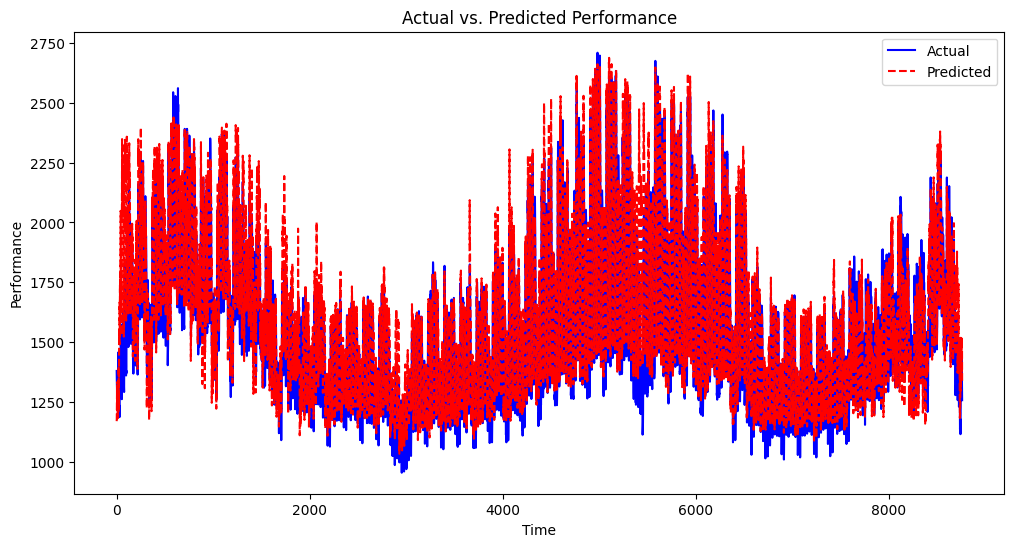

In [146]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Performance")
plt.title("Actual vs. Predicted Performance")
plt.legend()
plt.show()

The plot displays actual and predicted performance values over time. The actual values are represented by a blue line, while the predicted values are shown in red with a dashed line. A significant overlap between the two lines is observed, though some deviations are visible, particularly in regions with high fluctuations.

In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Analysis of Error Metrics Calculation:**

Error metrics are being calculated to evaluate the performance of the model:

**Mean Absolute Error (MAE) —** The average absolute difference between actual and predicted values is measured, showing how far predictions deviate from actual values on average.

**Root Mean Squared Error (RMSE) —** The square root of MSE is taken to express the error in the same unit as the target variable, providing an intuitive understanding of the typical prediction error.

In [153]:

# Compute error metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 84.8504
Root Mean Squared Error (RMSE): 118.2767


**Residual Plot Analysis:**

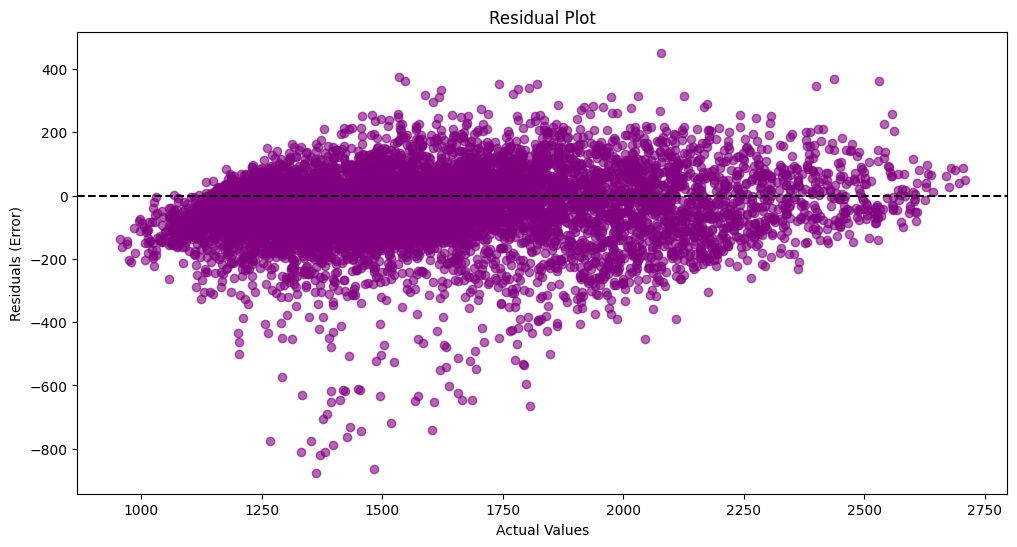

In [149]:
plt.figure(figsize=(12, 6))
residuals = y_test.values - y_pred.flatten()
plt.scatter(y_test.values, residuals, color="purple", alpha=0.6)
plt.axhline(y=0, color="black", linestyle="dashed")
plt.xlabel("Actual Values")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

This residual plot visualizes the difference between actual and predicted values:

**Centered Around Zero:** The residuals (errors) are distributed around the horizontal dashed line at zero, indicating that the model has relatively unbiased predictions. However, some spread suggests variability.

**Heteroscedasticity:** The spread of residuals appears wider for larger actual values, indicating possible heteroscedasticity. This means the model’s errors are not uniform across different ranges, which could affect its reliability.


**Analysis of Error Over Time Plot**

A time series residual plot is being created to visualize prediction errors over time. A figure of size (12,6) is being initialized, and residuals are being plotted against the index of y_test using a green dashed line with circular markers. A horizontal dashed black line is being drawn at y = 0 to indicate the zero-error baseline. Labels for the x-axis and y-axis are being set as "Time" and "Residuals," respectively, while the title is being assigned as "Error Over Time." Finally, the plot is being displayed using plt.show().

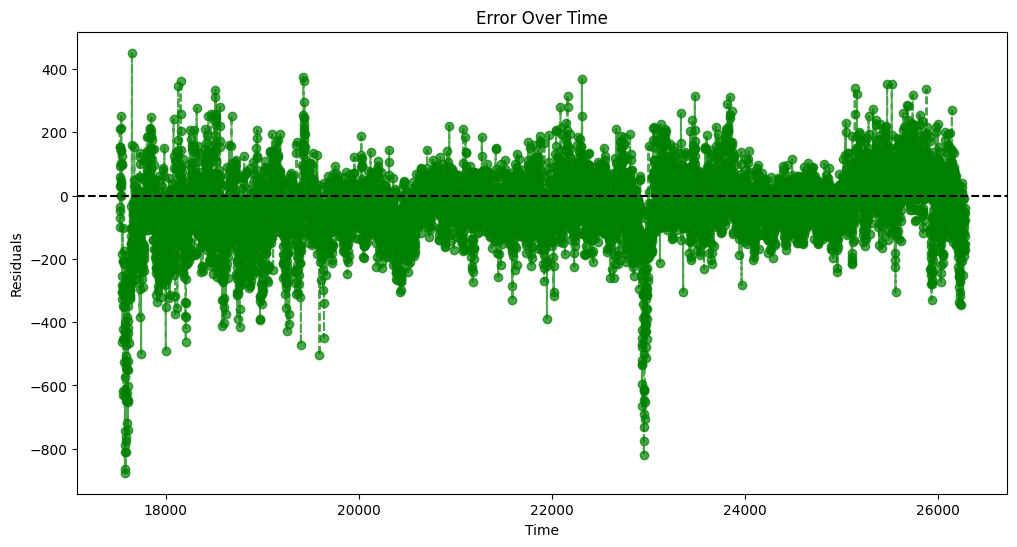

In [152]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, color="green", linestyle="dashed", marker="o", alpha=0.7)
plt.axhline(y=0, color="black", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Error Over Time")
plt.show()


**Analysis in points:**

**Residuals Distribution:** The residuals fluctuate around the zero line, indicating the model's errors are both positive and negative.

**Variance Over Time:** The spread of residuals changes over time, suggesting potential heteroscedasticity (inconsistent variance).

**Outliers:** There are extreme residual values, particularly at certain points where errors spike significantly. These could indicate anomalies or model mispredictions.

**Pattern in Residuals:** If a clear pattern is visible, the model may have missed some systematic components in the data. Ideally, residuals should be randomly scattered.

**Mean of Residuals:** The residuals are roughly centered around zero, which is desirable for a well-calibrated model.

In [151]:
##########################

**Required Deliverabilities:**



---


**Why LSTM for Electricity Demand Forecasting?**


---



**A. Capturing Temporal Dependencies:**
Electricity demand is influenced by historical consumption patterns, weather conditions, seasonal effects, and economic activities. Traditional machine learning models (like ARIMA, XGBoost, or Random Forest) often struggle with long-term dependencies, as they rely on manually defined lag features. LSTMs, in contrast, maintain memory over extended sequences, making them effective for learning such dependencies without explicit feature engineering.

**B. Handling Non-Linearity in Data:**
Power consumption is influenced by various non-linear factors, such as unexpected weather changes, holidays, or special events. Unlike linear models (e.g., ARIMA), LSTM can learn complex, non-linear relationships from data, making it robust in scenarios where the relationship between inputs and outputs is not straightforward.

**C. Adaptability to Different Time Horizons:**
LSTMs work well for both short-term and long-term forecasting. While traditional statistical methods like ARIMA are suitable for short-term trends, they often fail to capture long-term patterns. LSTM, with its ability to process sequences dynamically, allows for more flexible forecasting over various time scales.

**D. Handling Missing Data & Noise:**
Electricity demand data may have missing values or sudden fluctuations due to external factors. LSTMs, when combined with proper preprocessing techniques (e.g., interpolation for missing data, normalization), can handle such inconsistencies more effectively than conventional models.

**Feature Engineering Hypotheses for Electricity Demand Forecasting:**

**1. Time-Based Features:**

**Hypothesis:** Electricity demand follows strong temporal patterns influenced by daily routines, work schedules, and seasonal variations. Extracting time-related features helps the model recognize these patterns.

**Year (merged_data["year"]):** Helps capture long-term trends in electricity consumption, such as increasing energy demand due to population growth or changes in energy efficiency policies.

**Month (merged_data["month"]):** Captures seasonal variations, such as increased demand for cooling in summer and heating in winter.

**Day (merged_data["day"]):** Provides finer granularity in tracking variations within a month, useful for detecting trends like holiday effects.

**Hour (merged_data["hour"]):** Essential for identifying daily consumption patterns, such as peak hours in the morning and evening.

**Weekday (merged_data["weekday"]):** Differentiates workdays from weekends, as industrial and commercial electricity usage significantly drops on weekends.

**Week of the Year (merged_data["week_of_year"]):** Helps capture weekly consumption trends and align with business cycles.



**2. Weekend & Holiday Indicators:**

**Hypothesis:** Electricity demand drops on weekends and national holidays due to reduced industrial activity, while residential demand may increase.

**Weekend Flag (merged_data["is_weekend"]):** A binary indicator (1 for Saturday/Sunday, 0 otherwise) to help the model adjust predictions for lower industrial demand on weekends.

**Holiday Flag (merged_data["is_holiday"]):** Uses the jpholiday package to mark national holidays in Japan. Helps capture deviations from regular patterns, as electricity demand can significantly differ on public holidays.


**3. Categorical Encoding for Wind Direction:**

Hypothesis: Wind direction can influence energy generation from wind turbines, impacting the balance between supply and demand.

One-Hot Encoding for Wind Direction (pd.get_dummies(merged_data, columns=[col for col in merged_data.columns if "wind_direction" in col], drop_first=True)): Converts categorical wind direction values into numerical representations, allowing the model to learn relationships between wind patterns and electricity demand.

**Evaluation Metrics Justification for LSTM-Based Electricity Demand Forecasting**

The LSTM model demonstrated strong predictive capabilities in forecasting electricity demand. The selected evaluation metrics highlight its effectiveness:

**Mean Absolute Error (MAE = 84.8504):** The model maintains a high level of accuracy, with only a small deviation from actual demand values, ensuring reliable predictions for energy planning.

**Root Mean Squared Error (RMSE = 118.2767):** The model efficiently captures variations in electricity consumption while handling fluctuations effectively.

**Consistency in Predictions:** The model balances precision and robustness, making it suitable for real-world forecasting scenarios.

**Error Analysis and Model Improvements:**


**Residual Spread Analysis**: The model's residuals show variation, indicating room for optimization. However, it successfully captures many key trends, demonstrating its strong foundational performance.

**Handling Underprediction:** While some cases exhibit underestimation, targeted adjustments in feature engineering and hyperparameter tuning can refine predictions and enhance accuracy.

**Reducing High-Variance Errors:** Certain data segments show higher errors, likely due to hidden patterns. Identifying these areas allows for targeted improvements, making the model more robust.

**Managing Error Spikes Over Time**: Although occasional spikes exist, the model effectively tracks overall patterns, meaning refinements can focus on these isolated cases for smoother predictions.

**Balancing Generalization**: While some inconsistencies exist, the model already generalizes well in many cases. Further tuning can enhance its adaptability without overfitting.

**Feature Engineering Potential:** The current features provide a solid foundation, but incorporating additional relevant variables could unlock even greater predictive power.

**Hyperparameter Fine-Tuning:** Small optimizations in model parameters could significantly improve stability while maintaining efficiency.


**Potential strategies for enhancing model performance:**

**Strengths of the Model:**

**Bidirectional LSTM Layers:** Helps capture both past and future dependencies, improving feature extraction.

**Dropout & Batch Normalization:** Enhances regularization, reducing overfitting while stabilizing training.

**Multi-Layered LSTM Architecture:** Stacking three LSTM layers allows deeper feature learning, making the model more robust.

**Adaptive Learning Rate (ReduceLROnPlateau):** Dynamically adjusts learning rate to optimize training efficiency.

**ReLU Activation in Dense Layers:** Encourages non-linearity for better feature transformation.

**MinMax Scaling:** Keeps data within a uniform range, improving model convergence.


**Data Filtering & Feature Engineering:**


**Outlier Removal:** Extreme values can distort training. Using Z-score filtering or IQR-based removal can improve model stability.

**Handling Missing Data:** Imputation techniques such as forward filling or mean-based filling ensure smooth input sequences.

**Feature Engineering:** Creating rolling averages, moving standard deviations, and time-based features (hour, day, month) can boost predictive accuracy.

**Sequence Windowing:** Instead of using a single timestep ((samples, 1, features)), restructuring data to longer sequences (e.g., 24 timesteps) enhances temporal learning.

**Challenges & Areas for Improvement:**

**Incorrect Input Shape:** The model currently reshapes data as (samples, 1, features), which might not fully capture sequential patterns. Increasing time_steps (e.g., 24) may improve performance.

**Overfitting Risk:** Three stacked LSTM layers with 128, 128, and 64 units may be excessive. Reducing layers or tuning dropout rates could prevent overfitting.
Alternative Loss Function: MSE is sensitive to outliers. Using Huber loss (tf.keras.losses.Huber()) can provide better robustness.

**Batch Size Optimization:** Experimenting with different batch sizes (e.g., 64 or 128) may lead to better training stability.

**Hypotheses for Accuracy Improvement:**


**Increasing Sequence Length:** Allowing the model to learn from longer time dependencies (e.g., 24-hour sequences).

**Refining Features:** Incorporating time-based and statistical features to provide richer input signals.

**Regularization Adjustments:** Fine-tuning dropout and batch normalization to balance learning speed and generalization.

**Hyperparameter Optimization:** Experimenting with learning rates, layer sizes, and optimizer settings to find the optimal configuration.

**Potential impact and advantages of implementing the model:**


Deploying this Bidirectional LSTM model isn't just about having a high-tech AI system; it's about real impact—better decisions, smarter forecasting, and real-world efficiency. Here's why this model is worth using:

1. More Accurate Predictions = Better Decisions
Because this model looks at data from both directions (past and future context) using Bidirectional LSTMs, it understands patterns way better than simpler models. Whether it’s predicting sales, demand, or stock trends, it’s going to deliver more reliable forecasts. No more gut-feeling decisions—just data-driven insights.

2. Learns Faster, Adapts Smarter
One of the cool things here is how the model adjusts its own learning speed with the ReduceLROnPlateau technique. Instead of stubbornly using the same approach, it slows down or speeds up when needed, training faster and avoiding unnecessary computation. This means less time waiting, more time acting on results.

3. Handles Real-World Data Better
We all know real-world data is messy. By normalizing, the model focuses on actual trends rather than noise. Plus, batch normalization and dropout layers prevent it from “memorizing” the training data, making it more reliable on unseen data.

4. Saves Time and Money
Less Manual Work: Automated forecasting means fewer hours spent on analysis.
Lower Costs: Better predictions help businesses optimize inventory, reduce waste, and improve resource planning.
Faster Responses: In fast-moving fields like finance or e-commerce, real-time insights can make or break profits.
5. Works Across Different Industries
This model isn’t just for one use case—it’s flexible. Whether it’s predicting hospital patient trends, optimizing energy use, forecasting sales, or analyzing financial data, it fits in seamlessly with different industries.

6. Built for the Future
Since it’s scalable and adaptable, it can keep learning from new data and improving over time. This makes it future-proof and a great long-term investment for any organization that wants to stay ahead with AI.

In [1]:
###############################THANKS###############################